In this notebook example, we use the RSI PowerZones strategy on the SPY, and we test it for robustness using a variety of approaches.

More on the strategy in the book "Buy the fear, sell the greed" by Larry Connors (https://www.amazon.com/Buy-Fear-Sell-Greed-Behavioral/dp/0578206501)

In [68]:
import pandas as pd
import yfinance as yf
import talib
import vectorbt as vbt
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep
from itertools import product
from tqdm import tqdm
tqdm.pandas()

In [180]:
# Load data
data = yf.download('spy')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


### The Strategy

In [171]:
def strategy(data, sma_window, rsi_window, rsi_lower1, rsi_lower2, rsi_upper):

    # Computing indicators
    sma200 = data.rolling(sma_window).mean().shift(1)
    if len(data.shape) > 1:
        rsi4 = {} 
        for c in data.columns:
            rsi4[c] = talib.RSI(data[c], rsi_window)
        rsi4 = pd.DataFrame(rsi4)
    else:
        rsi4 = talib.RSI(data, rsi_window)
    # Generating signals
    entries = (data > sma200) & (rsi4.vbt.crossed_below(rsi_lower1) | rsi4.vbt.crossed_below(rsi_lower2))
    exits = rsi4.vbt.crossed_above(rsi_upper)
    
    # Run backtest
    pf = vbt.Portfolio.from_signals(data, entries, exits, size=100, size_type='value')

    return pf

<Axes: xlabel='Date'>

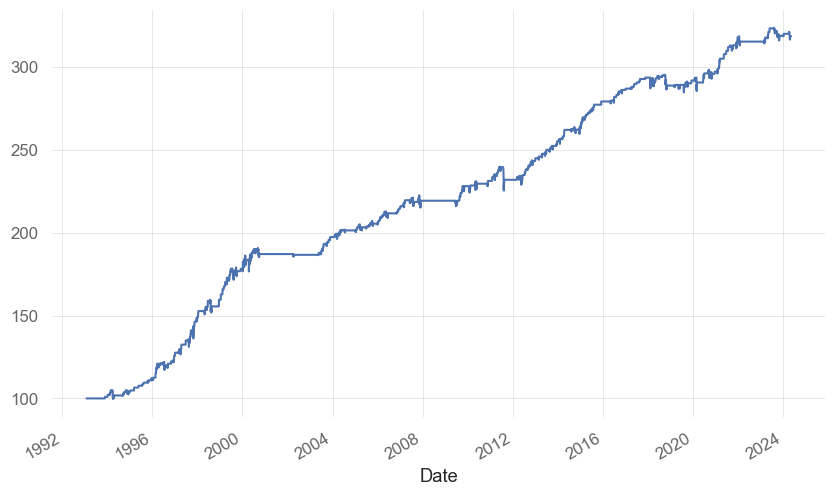

In [184]:
# Backtest selected parameters (derived from the book)
pf = strategy(data, 200, 4, 30, 25, 55)
pf.value().plot()

# Robustness Testing

### Different Timeframes

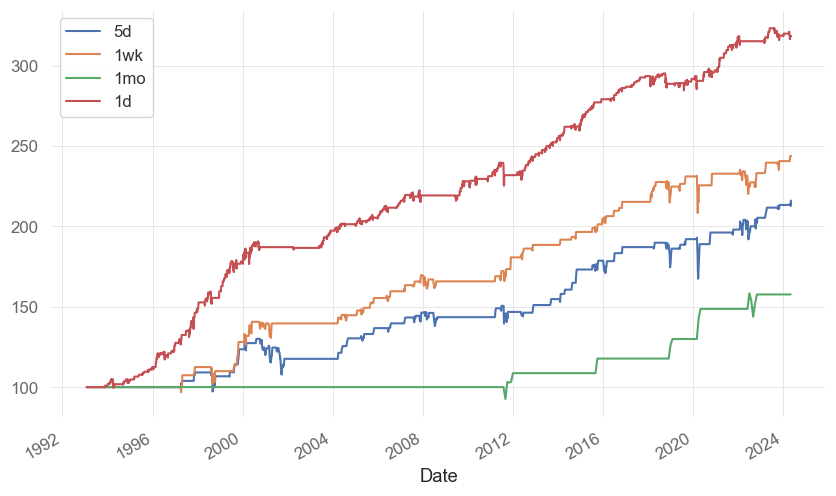

In [173]:
for tf in ['5d', '1wk', '1mo', '1d']:
    data = yf.download('SPY', interval=tf, progress=False)['Adj Close']
    pf = strategy(data, 200, 4, 30, 25, 55)
    pf.value().plot(label=tf)
plt.legend()

The strategy continues to be profitable across various timeframes, although returns decrease as the granularity increases. This is expected since higher timeframes typically involve fewer trades.





### Different (related) Markets

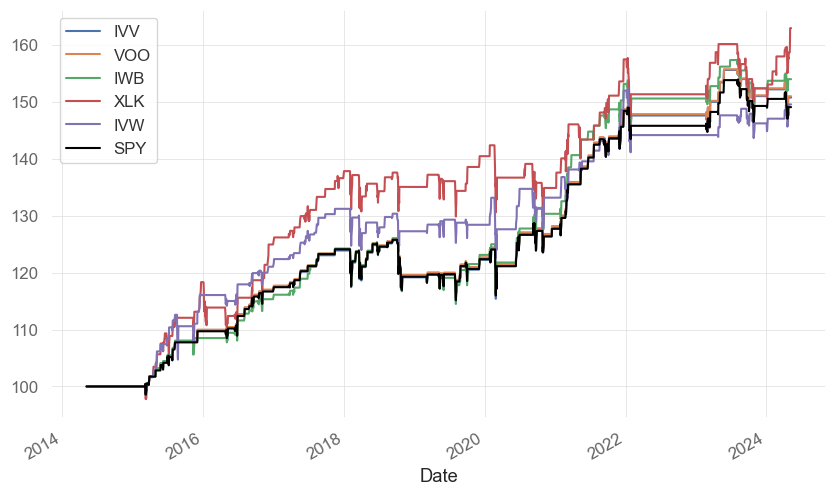

In [175]:
for market in ['IVV', 'VOO', 'IWB', 'XLK', 'IVW']:
    data = yf.download(market, progress=False, period='10y')['Adj Close']
    pf = strategy(data, 200, 4, 30, 25, 55)
    pf.value().plot(label=market)

data = yf.download('spy', progress=False, period='10y')['Adj Close']
pf = strategy(data, 200, 4, 30, 25, 55)
pf.value().plot(label='SPY', color='black')
plt.legend()

The strategy shows strong performance across most ETFs that have a high correlation with the SPY, indicating robustness, while for some it yields even better results.





### Monte Carlo Trade Reshuffling

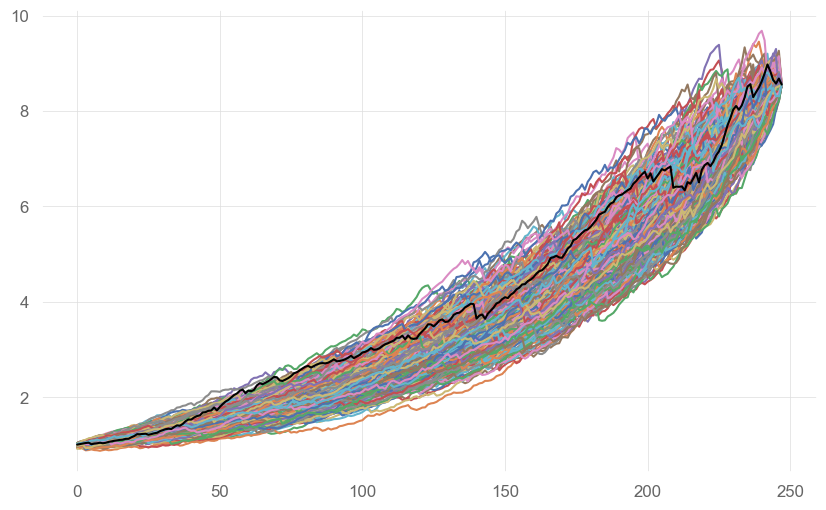

Max Drawdown Stats
-------------------


count    500.000000
mean      -0.068867
std        0.015717
min       -0.144833
25%       -0.076375
50%       -0.066229
75%       -0.058171
max       -0.038506
dtype: float64

In [185]:
trades=pf.trades.records_readable

n_simulations = 500
equity_curves = []

for i in range(n_simulations):
    shuffled_trades = np.random.permutation(trades.Return.to_numpy())
    equity_curve = pd.Series(shuffled_trades).add(1).cumprod()
    equity_curves.append(equity_curve)

pd.DataFrame(equity_curves).T.plot()
trades.Return.add(1).cumprod().plot(color='black')
plt.legend().set_visible(False)
plt.show()

print('Max Drawdown Stats')
print('-------------------')
t = pd.DataFrame(equity_curves).T + 1
t.pct_change().apply(ep.max_drawdown).describe()

This simulation suggests anticipating a drawdown of up to 14.4% in live trading. The proximity of the equity curves also signals robustness.





### Monte Carlo Return Reshuffling

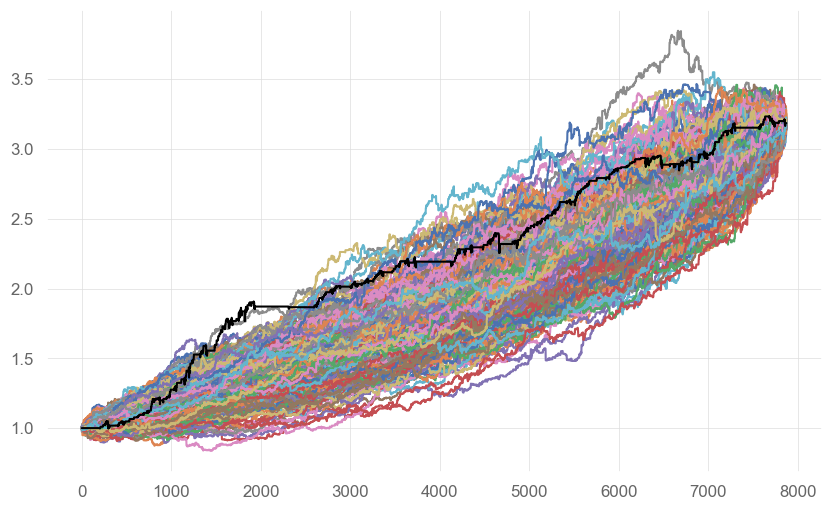

Max Drawdown Stats
-------------------


count    500.000000
mean      -0.059453
std        0.014340
min       -0.156564
25%       -0.067305
50%       -0.057204
75%       -0.050044
max       -0.032870
dtype: float64

In [186]:
ret=pf.returns()

n_simulations = 500
equity_curves = []

for i in range(n_simulations):
    shuffled_trades = np.random.permutation(ret.to_numpy())
    equity_curve = pd.Series(shuffled_trades).add(1).cumprod()
    equity_curves.append(equity_curve)

pd.DataFrame(equity_curves).T.plot()
ret.reset_index(drop=True).add(1).cumprod().plot(color='black')
plt.legend().set_visible(False)
plt.show()

print('Max Drawdown Stats')
print('-------------------')
t = pd.DataFrame(equity_curves).T + 1
t.pct_change().apply(ep.max_drawdown).describe()

This analysis reveals a less favorable scenario, indicating a potential maximum drawdown of 15.6%, which is still better than that of the underlying asset.





### Noise Testing

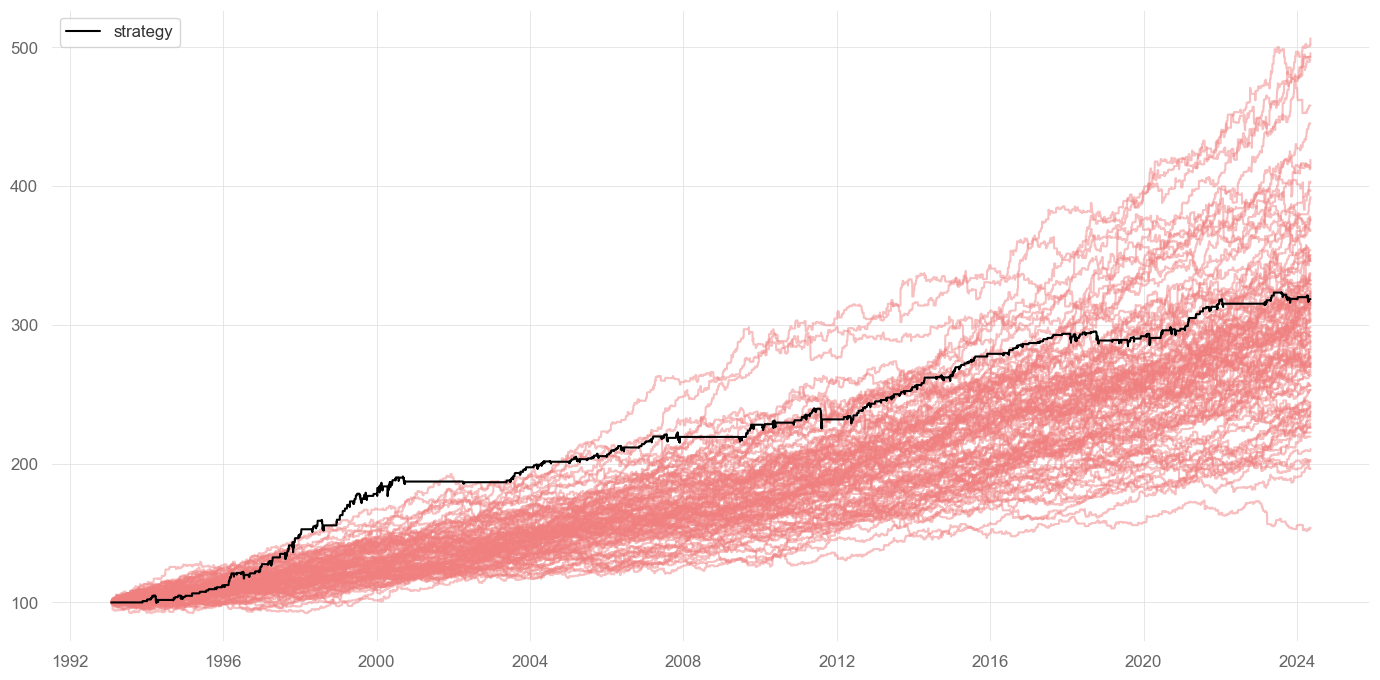

In [187]:
# This robustness test is all about testing the strategy on GBM generated prices

def gmb(returns, num_samples):
    resampled_returns = np.random.choice(returns, size=num_samples, replace=True)
    prices = [closing_prices.iloc[0]]
    for ret in resampled_returns:
        prices.append(prices[-1] * (1 + ret))
    return prices

closing_prices = pf.value()
returns = pf.returns()

# Generate 100 random prices, using geometric brownian motion
bootstrap_prices = [gmb(returns, len(closing_prices) - 1) for _ in range(100)]

# Plotting
plt.figure(figsize=(14,7))
for prices in bootstrap_prices:
    plt.plot(closing_prices.index, prices, color='lightcoral', alpha=0.5)

plt.plot(closing_prices.index, closing_prices, color='black', label='strategy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This test indicates that the strategy underperforms across various noise levels and fails to meet the criteria of this assessment.

### Parameter Permutation Testing

100%|██████████████████████████████████████████████████| 450/450 [00:08<00:00, 52.69it/s]


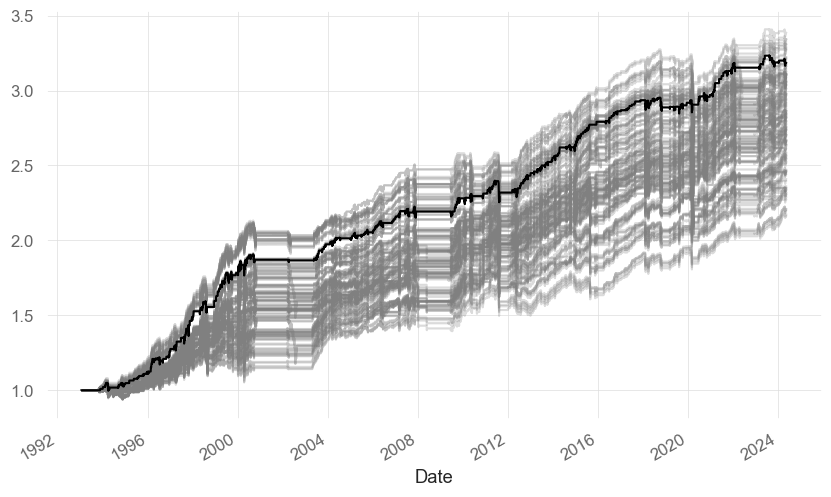

In [188]:
# Specify original parameters

params = [200, 4, 30, 25, 55]

# Specify parameter test ranges

param_ranges = [range(180, 230, 10), 
                range(2, 8, 2), 
                range(30, 40, 5), 
                range(20, 35, 5),
                range(45, 70, 5)]

# Run backtest on each permutation

v1, v2, v3, v4, v5 = param_ranges # replace with "perms_ranges" if automatic
perms_rets = {} 
for i, (x1, x2, x3, x4, x5) in tqdm(enumerate(list(product(v1, v2, v3, v4, v5))), total=len(list(product(v1, v2, v3, v4, v5)))):
    perms_rets[f'perm_{i}'] = strategy(data, x1, x2, x3, x4, x5).returns()


# Plotting

pd.DataFrame(perms_rets).add(1).cumprod().plot(color='grey', alpha=0.1)
strategy(data, 200, 4, 30, 25, 55).returns().add(1).cumprod().plot(color='black')
plt.legend().set_visible(False)
plt.show()

This evaluation suggests that the strategy demonstrates a degree of robustness to parameter changes.

## Variance Test

100%|███████████████████████████████████████████████| 1000/1000 [00:01<00:00, 862.85it/s]


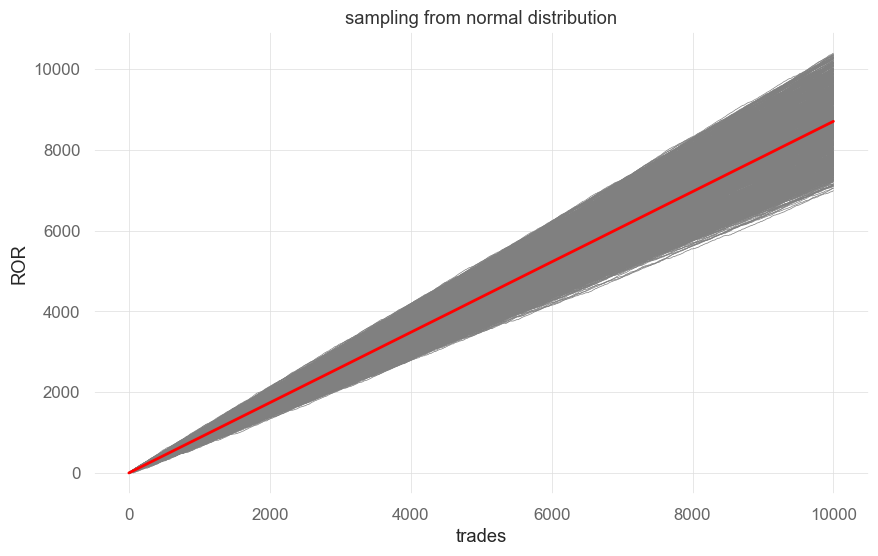

In [189]:
"""
Creates hypothetical equities of varying win rate (5% deviation from the original)

This test is critical, as it essentially summarizes what can happen if you allow 
the law of large numbers to play out, as it enables us to estimate where the equity may be after N trades.
    
More details here:
 - https://www.buildalpha.com/buildalpha-features/
 - https://www.linkedin.com/pulse/variance-testing-easy-way-detect-data-mining-bias-ali-h-askar-cqf/

"""

backtest_results = pf.trades.records_readable.PnL
n_simulations = 1000
n_trades = 10000 # specify according to the strategy's trading frequency (the higher the frequency, the higher the n_trades should be)
win_rate_variance = 0.05

# Calculate original win rate
original_win_rate = (backtest_results > 0).mean()

# Calculate win/loss average
pos = backtest_results[backtest_results>0].mean()
neg = backtest_results[backtest_results<0].mean()

# Initialize DataFrame to store results
results = pd.DataFrame(index=range(n_simulations), columns=['profit', 'drawdown'])
equity_curves_df = pd.DataFrame()
dd_df = {}


for i in tqdm(range(n_simulations)):
    # Adjust win rate within variance limits and make sure it's within [0, 1] range
    adjusted_win_rate = np.clip(original_win_rate + (np.random.rand() - 0.5) * 2 * win_rate_variance, 0, 1)

    # Sample trades with adjusted win rate
    _trades = np.random.choice([pos, neg], size=n_trades, p=[adjusted_win_rate, 1-adjusted_win_rate])
    
    # Calculate profit and equity curve
    profit = _trades.sum()
    equity_curve = np.cumsum(_trades)
    
    # Calculate maximum drawdown
    cummax = np.maximum.accumulate(equity_curve)
    drawdown = np.max(cummax - equity_curve)    

    equity_curves_df[i] = pd.Series(equity_curve)
    dd_df[i] = drawdown

# Plotting spaghetti chart
for i in range(n_simulations):
    plt.plot(equity_curves_df[i], color='gray', linewidth=0.5)

# Plotting mean equity curve
plt.plot(equity_curves_df.mean(axis=1), color='red', linewidth=2)
# plt.plot(rets.cumsum().values, color='green')
plt.title('sampling from normal distribution')
plt.xlabel('trades')
plt.ylabel('ROR')
plt.show()

This test shows that the strategy remains profitable in the long run, even with varying win rates, as demonstrated by the closely aligned equity values.



